In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Teste

In [2]:
# Importação das bibliotecas

from IPython.display import display, Javascript, Image
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import numpy
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Função read_images 

> Essa função irá pegar a pasta do drive e o tamanho desejado da imagem e retornará os nomes, o vetor de imagens a serem utilizadas e um vetor com as labels

In [3]:
def read_images(path, image_size):
  names = []
  training_images, training_labels = [], []
  label = 0

  # dirname - nome da pasta principal do drive
  # subdirname - nome da pasta dentro da pasta principal do drive
  # filenames - nome das imagens

  for dirname, subdirnames, filenames in os.walk(path):
    for subdirname in subdirnames:
        names.append(subdirname)
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
          img = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)
          if img is None:
            # The file cannot be loaded as an image.
            # Skip it.
            continue
          img = cv2.resize(img, image_size)
          training_images.append(img)
          training_labels.append(label)
        label += 1
  training_images = numpy.asarray(training_images, numpy.uint8)
  training_labels = numpy.asarray(training_labels, numpy.int32)
  return names, training_images, training_labels


> Nessa célula será salvo a pasta com as imagens, o tamanho final das imagens e será chamada a função read_images




In [4]:
path_images = '/content/gdrive/MyDrive/Photos/Recortes'
image_size = (120, 120)
names, images, labels = read_images(path_images, image_size)

> O print será responsável por verificar o conjunto de nomes e o vetor que contem as training labels e mais para frente do programa será comparado o training_labels com o valor de predição

In [5]:
print(names,'\n', labels)

['Alba', 'Vinicius', 'Elton', 'Joao'] 
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


#Mostrando um exemplo 

<class 'numpy.ndarray'>
(120, 120)
['Alba', 'Vinicius', 'Elton', 'Joao']


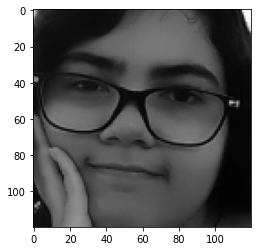

In [6]:
plt.imshow(images[1], cmap='gray')
print(type(images[0]))
print(images[0].shape)
print(names)

#Separando modelo de treino e teste

In [7]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(images, labels, random_state=10)


> Para a predição das imagens, foi necessário da um reshape

In [8]:
nsamples_i, nx_i, ny_i = Xtrain.shape
train_images = Xtrain.reshape((nsamples_i, nx_i*ny_i))

nsamples_i, nx_i, ny_i = Xtest.shape
test_images = Xtest.reshape((nsamples_i, nx_i*ny_i))


> Utilizando o PCA para analizar os componentes principais das fotos e armazenamento

- Modelo utilizado é o SVM não linear

(18, 14400)
(18, 11)


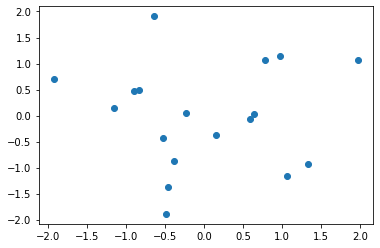

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=11, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

print(test_images.shape)
pca_images = pca.fit_transform(test_images)
print(pca_images.shape)
plt.scatter(pca_images[:,0], pca_images[:,1])

# Utilizando cálculo de peso (gama e C) para treinar o modelo 

In [10]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(pca_images, ytest)
print(grid.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


CPU times: user 221 ms, sys: 4.18 ms, total: 225 ms
Wall time: 227 ms
{'svc__C': 50, 'svc__gamma': 0.005}


#Mostrando a quantidade de imagens do Dataset


In [11]:
print(labels.size)
print(Xtrain.shape)
print(Xtest.shape)

69
(51, 120, 120)
(18, 120, 120)


#Predizendo os valores de pca

In [12]:
model = grid.best_estimator_
yfit = model.predict(pca_images)
print(names)
print(ytest)
print(yfit)

['Alba', 'Vinicius', 'Elton', 'Joao']
[3 0 0 0 1 1 3 2 2 3 3 1 1 1 2 2 3 0]
[3 0 0 0 1 1 3 2 2 3 3 1 1 1 2 2 3 0]


#Representação visual das imagens analizadas e da predição
> imagens com predição diferente da correta o texto no nome predito será em vermelho e quando o nome predito é igual ao nome da pessoa, o texto será em preto

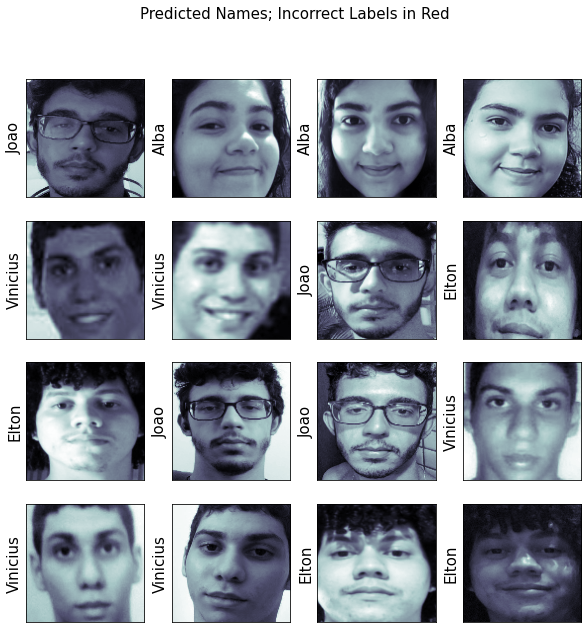

In [13]:
fig, ax = plt.subplots(4, 4, figsize = (10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(120, 120), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(names[yfit[i]].split()[-1], color='black' if yfit[i] == ytest[i] else 'red', fontsize = 15)
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=15);

#*Classification report* para analisar a %

> Será observado os valores da coluna: recall

In [14]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,target_names = names))

              precision    recall  f1-score   support

        Alba       1.00      1.00      1.00         4
    Vinicius       1.00      1.00      1.00         5
       Elton       1.00      1.00      1.00         4
        Joao       1.00      1.00      1.00         5

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

